<a href="https://colab.research.google.com/github/AeraVentis/Blur_detection/blob/main/Blure_detection_Oleg_Sharshon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  SHIFT CV WINTER 2023  
## Blurred images detection  
Выполнил: Олег Шаршонь (FOCUSSTART-36537)


Идея данного ноутбука взята из "[Baseline Notebook](https://www.kaggle.com/code/amlekomtsev/baseline)" и "[Blur detection with feature Engineering](https://www.kaggle.com/code/harininarasimhan/blur-detection-with-feature-engineering/notebook)"

Судя по liderboard,  выделение агрегированных свойств изображений не самый лучший подход для классификации по наличию заблюренности. Анализируя ошибки предсказания (как FN, так и FP) видно несколько проблем такого подхода. 
1. Датасет имеет изображения в которых место расположения блюра имеет важное значение. Например, центральная часть в фокусе, а окружающие объекты (переднего или заднего плана) вне фокуса.
2. Тени вызывают ложное срабатывание классификатора, потому что имеют размытые границы по своей природе.
3. Motion blur  имеет сложную структуру контуров (я бы назвал этом "множественные четкие котуры") и сложен для детектирования.

Хотелось бы реализовать алгоритм выделения свойств контуров объектов на изображении, например, удельная размытость контуров, имеющая привязку к геометрическому расположению на фото. Наданный момент моей экспертности для этого недостаточно.

## Prepare the environment

In [1]:
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname))

In [2]:
#!pip install -q ipyplot

In [3]:
import os
import numpy as np
import pandas as pd
import glob
#from ipyplot import plot_images
import cv2

import torch
from torchvision import transforms

from tqdm import tqdm
from PIL import Image
from skimage.filters import laplace, sobel, roberts

from sklearn.model_selection import train_test_split # разделение датасета
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.tools.tools import add_constant
from patsy import dmatrices

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# https://stackoverflow.com/questions/65827830/disabledfunctionerror-cv2-imshow-is-disabled-in-colab-because-it-causes-jupy
# патч для работы imshow в Google Colab
# from google.colab.patches import cv2_imshow

## Paths

In [5]:
# /kaggle/input/shift-cv-winter-2023/train.csv
# /kaggle/input/shift-cv-winter-2023/test/test
# /kaggle/input/shift-cv-winter-2023/train/train

In [6]:
train_pth = '/kaggle/input/shift-cv-winter-2023/train/train'
tr_csv_path = '/kaggle/input/shift-cv-winter-2023/train.csv'

## DataFrame

In [7]:
df_train = pd.read_csv(tr_csv_path, dtype={'blur':int})
print(len(df_train))
# out: 2664

2664


In [8]:
print(df_train.head(3), df_train.shape, sep='\n')  # filename, blur

                   filename  blur
0  kagouracdzwrjjxzzedi.jpg     0
1  ahnamimqdfqoqdnozabc.jpg     0
2  gwhdadvghuzinmzhzssx.jpg     0
(2664, 2)


## Define

In [9]:
convert_tensor = transforms.ToTensor()

In [10]:
# set the work dir path

def set_dir(path):
  os.chdir(path)
  print(os.getcwd())
  file_list = os.listdir()
  return file_list

In [11]:
# перед запуском установить рабочую директорию

def ftrs_extrctn(df):
  features=[]
  for im_pth in tqdm(df['filename']):
    gray_img2 = cv2.imread(str(im_pth),0)
    #gray_img2 = cv2.Laplacian(gray_img2, -1, ksize=5, scale=1,delta=0, borderType=cv2.BORDER_DEFAULT)
    gray_img2 = gray_img2[50:590, 50:590]


    tv_feat = calc_tv_measure(gray_img2)
    fft_feat = calc_fft_measure(gray_img2)
    lpl_feat = laplace(gray_img2)
    sbl_feat = sobel(gray_img2)
    rbt_feat = roberts(gray_img2)

    features.append([im_pth, lpl_feat.mean(),lpl_feat.var(),np.amax(lpl_feat),\
                   sbl_feat.mean(),sbl_feat.var(),np.max(sbl_feat),\
                   rbt_feat.mean(),rbt_feat.var(),np.max(rbt_feat),\
                   fft_feat, tv_feat])
  
  return features

In [12]:
# Baseline notebook

def calc_tv_measure(gray_img):

    gray_img = convert_tensor(gray_img)

    gray_img = gray_img.detach().clone()
    gray_img = gray_img[:, gray_img.shape[1]//4:3*gray_img.shape[1]//4,gray_img.shape[2]//4:3*gray_img.shape[2]//4]
    
    w_variance = torch.sum(torch.pow(gray_img[:, :, 1:] - gray_img[:, :, :-1], 2), dim=[1, 2])
    h_variance = torch.sum(torch.pow(gray_img[:, 1:, :] - gray_img[:, :-1, :], 2), dim=[1, 2])

    l2_score = (h_variance + w_variance)

    w_variance = torch.sum(torch.abs(gray_img[:, :, 1:] - gray_img[:, :, :-1]), dim=[1, 2])
    h_variance = torch.sum(torch.abs(gray_img[:, 1:, :] - gray_img[:, :-1, :]), dim=[1, 2])
    
    l1_score = (h_variance + w_variance)
    
    tv_measure = (l1_score/l2_score).numpy()[0]
    
    return tv_measure

In [13]:
# Baseline notebook
# https://pyimagesearch.com/2020/06/15/opencv-fast-fourier-transform-fft-for-blur-detection-in-images-and-video-streams/
# https://stackoverflow.com/questions/71677123/image-processing-for-blur-detection

def calc_fft_measure(gray_img, size=40):
    """ Определение заблюренности изображения с помощью Fourier transform:

    - Изображение переводится в частотный спектр с помощью fft, производится сдвиг начала координат и
    зануляется низкочастотный спектр.
    - Частотный спектр переводится обратно в изображение с помощью inverse fft.
    - Считается магнитуда, определяется уровень заблюренности картинки.
    Чем больше полученное значение, тем более размыто изображение
    """
    (h, w) = gray_img.shape
    (cx, cy) = (int(w / 2.0), int(h / 2.0))
    fft = np.fft.fft2(gray_img)
    fftShift = np.fft.fftshift(fft)

    fftShift[cy - size:cy + size, cx - size:cx + size] = 0
    fftShift = np.fft.ifftshift(fftShift)
    recon = np.fft.ifft2(fftShift)
    
    magnitude = 20 * np.log(np.abs(recon))
    mean = 1/np.average(magnitude)

    return mean

## Getting the features

In [14]:
set_dir(train_pth)

/kaggle/input/shift-cv-winter-2023/train/train


['wmunvmbcxdnqeuznlese.jpg',
 'olelwtwthhiteprdavku.jpg',
 'lsdgodykhcjruwakzcsx.jpg',
 'znbkajavjqomfvnzrmah.jpg',
 'lmrysxrruynwyrmmjvaz.jpg',
 'odxudopnryxnvblsxnwm.jpg',
 'hxdjdvpikbnewxzvqgnd.jpg',
 'cwnnqatbopjjtnmupgvg.jpg',
 'iekimveyrxbdvtjgonoe.jpg',
 'wtbghlfvgzoyxhudtehy.jpg',
 'elvomeqlpbqgrsjvnjqf.jpg',
 'ntwevfbfsyrpdieuklrt.jpg',
 'sthpmfuyflvhgayxvtfn.jpg',
 'ziaqdpafcaltyxvoczrk.jpg',
 'nxbqdfktwjiuufcqhjaq.jpg',
 'toqherezursaomguxwwt.jpg',
 'afkkshnudepwayyrooqt.jpg',
 'vssdzygnnilkztqpalch.jpg',
 'ulhiatgxyirailubovpo.jpg',
 'cwzasnxuukcgevatzeym.jpg',
 'djedikqaolwjdupasnvs.jpg',
 'zelwrmbcrqnecatwhlvt.jpg',
 'pqpruuhacodpccizzyud.jpg',
 'lfnpgrvzpqftolvohqnd.jpg',
 'zakrigssggdzqxffkhpg.jpg',
 'asbmkvbdbkranqkmyxyc.jpg',
 'puwnsmtlryekjpglynca.jpg',
 'khxdonarvkvjlrdqxkvb.jpg',
 'yrfnvkpgxswrpwaumufx.jpg',
 'yozmxmxiinohxubokezu.jpg',
 'dssjsukhwcasdkfvthrh.jpg',
 'kzztpjabfcwtboopqqlz.jpg',
 'pzvyzwcutcfvulztkpjd.jpg',
 'lzhzyprkqviyqtthckng.jpg',
 'dhxisnnkdmlq

In [15]:
tr_ftrs = ftrs_extrctn(df_train)

100%|██████████| 2664/2664 [03:15<00:00, 13.64it/s]


In [16]:
clmns=['image', 'Lpl_Mean', 'Lpl_Var', 'Lpl_Max', 'Sbl_Mean', 'Sbl_Var', 'Sbl_Max', 'Rbt_Mean', 'Rbt_Var', 'Rbt_Max', 'fft_feat', 'tv_feat']

In [17]:
ftrs_df = pd.DataFrame(tr_ftrs, columns=clmns)
ftrs_df.head(3)

,image,Lpl_Mean,Lpl_Var,Lpl_Max,Sbl_Mean,Sbl_Var,Sbl_Max,Rbt_Mean,Rbt_Var,Rbt_Max,fft_feat,tv_feat
0,kagouracdzwrjjxzzedi.jpg,-5.261757e-19,0.005686,0.835294,0.037452,0.002806,0.595749,0.032187,0.002284,0.559102,0.030203,10.382713
1,ahnamimqdfqoqdnozabc.jpg,1.172664e-19,0.016085,1.388235,0.047829,0.007164,0.677087,0.042674,0.006380,0.676610,0.025919,5.108372
2,gwhdadvghuzinmzhzssx.jpg,-3.245765e-19,0.006037,1.243137,0.030820,0.004115,0.662509,0.025897,0.003150,0.691582,0.034899,7.154258


In [18]:
# Объединение датафрейма с ответами (df_train) и 
# сгенерированных признаков (ftrs_df)

df_train = df_train.join(ftrs_df)
df_train.head(3)

,filename,blur,image,Lpl_Mean,Lpl_Var,Lpl_Max,Sbl_Mean,Sbl_Var,Sbl_Max,Rbt_Mean,Rbt_Var,Rbt_Max,fft_feat,tv_feat
0,kagouracdzwrjjxzzedi.jpg,0,kagouracdzwrjjxzzedi.jpg,-5.261757e-19,0.005686,0.835294,0.037452,0.002806,0.595749,0.032187,0.002284,0.559102,0.030203,10.382713
1,ahnamimqdfqoqdnozabc.jpg,0,ahnamimqdfqoqdnozabc.jpg,1.172664e-19,0.016085,1.388235,0.047829,0.007164,0.677087,0.042674,0.006380,0.676610,0.025919,5.108372
2,gwhdadvghuzinmzhzssx.jpg,0,gwhdadvghuzinmzhzssx.jpg,-3.245765e-19,0.006037,1.243137,0.030820,0.004115,0.662509,0.025897,0.003150,0.691582,0.034899,7.154258


In [19]:
# Эта ячейка использовалась при работе в Google Colab, потому что, по моему субъективному мнению, платформа Kaggle не удобна. 
# 
# Запись на диск и выгрузка датафрейма для экономии времени при открытии новой сессии Google Colab
#df_train.to_pickle('/content/drive/MyDrive/Colab Notebooks/InternShipS/ShiftCFT/all_ftrs_26122022.pkl')
#df_train = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/InternShipS/ShiftCFT/all_ftrs_26122022.pkl')

In [20]:
# Удаление из датафрейма столбцов с именами файлов

df_train = df_train.drop(['filename', 'image'], axis=1)
df_train.head(1)

,blur,Lpl_Mean,Lpl_Var,Lpl_Max,Sbl_Mean,Sbl_Var,Sbl_Max,Rbt_Mean,Rbt_Var,Rbt_Max,fft_feat,tv_feat
0,0,-5.261757e-19,0.005686,0.835294,0.037452,0.002806,0.595749,0.032187,0.002284,0.559102,0.030203,10.382713


In [21]:
# Экперимент с проверкой влияния мультиколлинеарности на работу SVM
# P. S. Практически не влияет

#df_train = df_train.drop(['Sbl_Mean', 'Rbt_Var'], axis=1)

In [22]:
# Запись на диск и выгрузка датафрейма без столбцов имён файов
# для экономии времени при открытии новой сессии Google Colab

# df_train.to_pickle('/content/drive/MyDrive/Colab Notebooks/InternShipS/ShiftCFT/all_ftrs_no_imgs_26122022.pkl')
# df_train = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/InternShipS/ShiftCFT/all_ftrs_no_imgs_26122022.pkl')

# Multicollinearity
Источник: https://pythonpip.ru/examples/obnaruzhenie-multikollinearnosti-vif-v-python

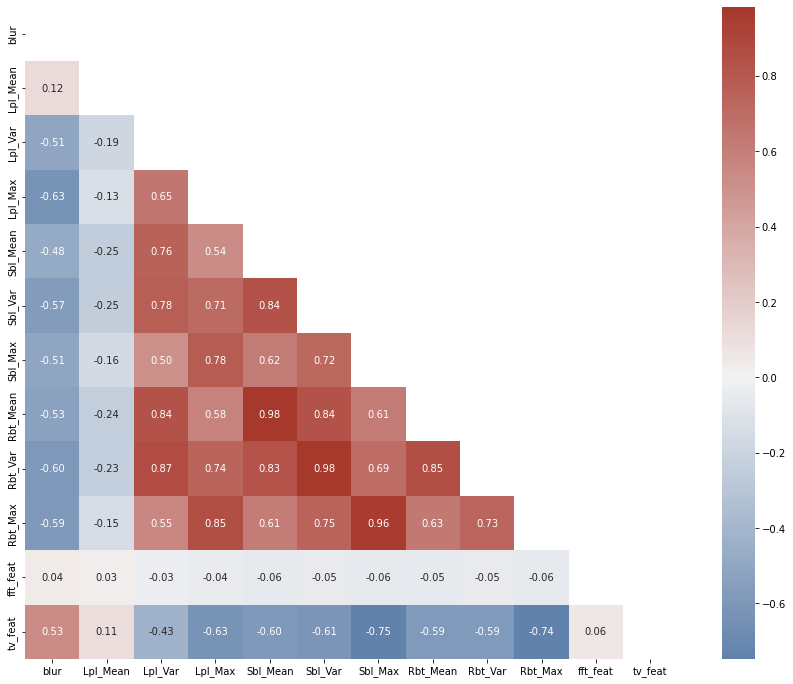

In [23]:
# Отображение нижней части матрицы корреляции, без дублирующей верхней части и диагонали
# https://habr.com/ru/company/otus/blog/559666/

matrix = df_train.corr()
mask = np.triu(np.ones_like(matrix, dtype=bool))
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

plt.figure(figsize=(16, 12))

sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap)

plt.show();

Multicollinearity-II
https://www.codecamp.ru/blog/how-to-calculate-vif-in-python/

In [24]:
#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('blur ~ Lpl_Mean+Lpl_Var+Lpl_Max+Sbl_Mean+Sbl_Var+Sbl_Max+Rbt_Mean+Rbt_Var+Rbt_Max+fft_feat+tv_feat', data=df_train, return_type='dataframe') # Rbt_Mean+Rbt_Var+Rbt_Max+

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable 
vif

,VIF,variable
0,52.410615,Intercept
1,1.087079,Lpl_Mean
2,18.862513,Lpl_Var
3,5.263208,Lpl_Max
4,110.555349,Sbl_Mean
5,121.605752,Sbl_Var
6,15.369470,Sbl_Max
7,128.957281,Rbt_Mean
8,161.890856,Rbt_Var
9,21.118612,Rbt_Max


# Prepare Train & Test DF

## PCA

In [25]:
# pca = PCA().fit(df_train)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

In [26]:
# PCA не "сработало", лучший результат 
# 0.8836772983114447 при C=400,kernel='rbf'

# pca = PCA(n_components=4)
# df_train_pca = pca.fit_transform(X_train)

## Prepare Train & Test DF

In [27]:
# Подготовка набора данных для обучения и проверки точности

# Копирование   столбца ответов (blur)
y_train = df_train['blur']
#y_test = test[:, 0]

# Удаление первого столбца с номерами букв
X_train = df_train.loc[:, 'Lpl_Mean':]
#X_test = test[:, 1:]

In [28]:
# Подготовка полного набора для обучения и послед применения для предсказания на тестовом наборе

X_tr_tr, y_tr_tr = X_train, y_train

In [29]:
# Разделение набора данных на тренировочный и проверочный наборы в пропорции 80%/20%
# Без перемешивания

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [30]:
print('X_train = ', X_train.shape, '\n', 'X_valid=', X_valid.shape, '\n', 'y_train = ', y_train.shape, '\n', 'y_valid = ', y_valid.shape)

X_train =  (2131, 11) 
 X_valid= (533, 11) 
 y_train =  (2131,) 
 y_valid =  (533,)


In [31]:
# Проверка работы классификатора на наборе без нормализации данных
# 

c_svm = SVC(gamma='auto') 
c_svm.fit(X_train, y_train)

pred_svc = c_svm.predict(X_valid)
accuracy_score(y_valid, pred_svc)

0.8142589118198874

In [32]:
# На нормализованном наборе с параметрами ядра SVC(kernel='poly', degree=3)) было получено 0.8311444652908068
# 0.9568 на 7 фичах "Lpl_Mean Lpl_Var Lpl_Max Sbl_Var Sbl_Max Rbt_Mean fft_feat"
# но судя по результату на kaggle это overfitting

svm_clf = make_pipeline(StandardScaler(), SVC(C=2150,kernel='rbf'))
svm_clf.fit(X_train, y_train)

pred_svc = svm_clf.predict(X_valid)
accuracy_score(y_valid, pred_svc)

0.9399624765478424

In [33]:
# PCA

# svm_clf = make_pipeline(StandardScaler(), SVC(C=400,kernel='rbf'))
# svm_clf.fit(X_train, y_train)

# pred_svc = svm_clf.predict(X_valid)
# accuracy_score(y_valid, pred_svc)

In [34]:
# pred_svc = svm_clf.predict(X_valid)
# accuracy_score(y_valid, pred_svc)

## Test prediction

In [35]:
svm_clf = make_pipeline(StandardScaler(), SVC(C=2150,kernel='rbf', probability=True))
svm_clf.fit(X_tr_tr, y_tr_tr)  # 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=2150, probability=True))])

In [36]:
test_pth = '/kaggle/input/shift-cv-winter-2023/test/test'
os.chdir(test_pth)
print('Current folder is: ', os.getcwd())
tst_file_list = os.listdir()
print('A sample of filename: ', tst_file_list[10])

Current folder is:  /kaggle/input/shift-cv-winter-2023/test/test
A sample of filename:  dufxhphtkcneaaxcoqlf.jpg


In [37]:
df_test = pd.DataFrame(tst_file_list, columns=['filename'])
df_test.head(3)

,filename
0,sayzffvvevfqhcvbidcl.jpg
1,momggphlkddgzvoyoiub.jpg
2,axwqnvsyiuqhfygkwmmo.jpg


In [38]:
feat_tst = []

In [39]:
for im_pth in tqdm(df_test['filename']):
  gray_img2 = cv2.imread(str(im_pth),0)
  
  tv_feat = calc_tv_measure(gray_img2)
  fft_feat = calc_fft_measure(gray_img2)
  lpl_feat = laplace(gray_img2)
  sbl_feat = sobel(gray_img2)
  rbt_feat = roberts(gray_img2)
  
  feat_tst.append([im_pth, lpl_feat.mean(),lpl_feat.var(),np.amax(lpl_feat),\
                   sbl_feat.mean(),sbl_feat.var(),np.max(sbl_feat),\
                   rbt_feat.mean(),rbt_feat.var(),np.max(rbt_feat),\
                   fft_feat, tv_feat])

100%|██████████| 774/774 [01:16<00:00, 10.13it/s]


In [40]:
clmns=['image', 'Lpl_Mean', 'Lpl_Var', 'Lpl_Max', 'Sbl_Mean', 'Sbl_Var', 'Sbl_Max', 'Rbt_Mean', 'Rbt_Var', 'Rbt_Max', 'fft_feat', 'tv_feat']

In [41]:
ftrs_df_tst = pd.DataFrame(feat_tst, columns=clmns)
ftrs_df_tst.head(1)

,image,Lpl_Mean,Lpl_Var,Lpl_Max,Sbl_Mean,Sbl_Var,Sbl_Max,Rbt_Mean,Rbt_Var,Rbt_Max,fft_feat,tv_feat
0,sayzffvvevfqhcvbidcl.jpg,-1.320558e-18,0.009074,1.121569,0.047011,0.003303,0.567167,0.041461,0.002724,0.631975,0.026307,11.807869


In [42]:
df_tst_no_img = ftrs_df_tst.drop(['image'], axis=1)
df_tst_no_img.head(3)

,Lpl_Mean,Lpl_Var,Lpl_Max,Sbl_Mean,Sbl_Var,Sbl_Max,Rbt_Mean,Rbt_Var,Rbt_Max,fft_feat,tv_feat
0,-1.320558e-18,0.009074,1.121569,0.047011,0.003303,0.567167,0.041461,0.002724,0.631975,0.026307,11.807869
1,-9.419006e-20,0.000282,0.235294,0.013187,0.000314,0.260895,0.010317,0.000194,0.245106,0.090734,39.314880
2,-1.055335e-18,0.005628,1.129412,0.030531,0.004127,0.688971,0.025370,0.003034,0.758801,0.032674,7.144684


In [43]:
pred_ProB_tst = svm_clf.predict_proba(df_tst_no_img)[:,1]

In [44]:
pred_ProB_tst = np.round(pred_ProB_tst, 1)

In [45]:
df_prob = pd.DataFrame(pred_ProB_tst)
df_prob.head(3)

,0
0,0.0
1,1.0
2,0.1


In [46]:
df_submission = pd.concat([ftrs_df_tst['image'], df_prob[0]], axis=1, keys=['filename', 'blur'])

In [47]:
df_submission.to_csv('/kaggle/working/subm8.csv', index=False)